# Example mean field game system solution

In [ ]:
#simple direct problem solving 
import matplotlib.pyplot as plt

from clspde.solution import Solution
from clspde.basis import Basis
import itertools
import numpy as np

power = 6
params = {
        'n_dims': 2,
        'dim_sizes': np.array([2, 2]),
        'area_lims': np.array([[0,0.1], [0,1]]),
        'power': power,
        'basis': Basis(power),
        'n_funcs': 2,
    }

def prepare_model(border_weight, colloc_weight, connect_weights):
    eps = 0.5

    sol = Solution(**params)

    w = 1
    k1 = connect_weights[0]
    k2 = connect_weights[1]



    colloc_left_operators = [lambda u_loc, u_bas, x, x_loc:  (u_bas([1,0],0)-eps*u_bas([0,2],0)
                                                                                                -(u_bas([0,1],0)*u_loc([0,1],1)+
                                                                                                
                                                                                                u_bas([0,0],0)*u_loc([0,2],1))
                                                                                            ) * w**2*colloc_weight,

                            lambda u_loc, u_bas, x, x_loc:  (-u_bas([1,0],1)-eps*u_bas([0,2],1)
                                                                                                +(u_bas([0,1],1)*u_loc([0,1],1))
                                                                                                ) * w**2*colloc_weight ,
                                                                                                ]


    def popravka(f,g):
        return f*g
    colloc_right_operators = [lambda u_loc, u_nei, x, x_loc: (0) * w**2*colloc_weight,
                            lambda u_loc, u_nei, x, x_loc: (popravka(u_loc([0,1],1),  u_loc([0,1],1))/2) * w**2*colloc_weight,
                            ]

    
    colloc_ops = [colloc_left_operators, colloc_right_operators]


    def initial_state(x):
        t, x = x
        return x+1

    def terminal_state(x):
        t, x = x
        return -2*eps*np.log(x+1)
        
    small = 1e-5

    def Bx(x):
        #border condition for x
        # return int((x[0]>sol.area_lims[0,0]+small) and (x[0]<sol.area_lims[0,1]-small))
        return int((x[1]==sol.area_lims[1,0]) or (x[1]==sol.area_lims[1,1]))

    def BtI(x):
        #border condition Initial for t
        return int(x[0]==sol.area_lims[0,0])

    def BtT(x):
        #border condtition Terminal for t
        return int(x[0]==sol.area_lims[0,1])

    border_left_operators = [
        lambda _, u_bas, x, x_loc: Bx(x)*(u_bas([0,0],1)) * border_weight,
        # lambda _, u_bas, x, x_loc: BtT(x)*(u_bas([0,0],0)-u_bas([0,0],1)) * border_weight, 
        lambda _, u_bas, x, x_loc: BtT(x)*(u_bas([0,0],1)) * border_weight, 
        
        # lambda _, u_bas, x, x_loc: BtI(x)*u_bas([0,0],0) * border_weight,

        lambda _, u_bas, x, x_loc: Bx(x)*u_bas([0,0],0) * border_weight,
        lambda _, u_bas, x, x_loc: BtI(x)*u_bas([0,0],0) * border_weight,
        # lambda _, u_bas, x, x_loc: BtT(x)*u_bas([0,0],0) * border_weight,
        ]

    border_right_operators = [
        lambda u, _, x, x_loc: Bx(x)* terminal_state(x) * border_weight,
        # lambda u, _, x, x_loc: BtT(x) * (initial_state(x) - terminal_state(x)) * border_weight, 
        lambda u, _, x, x_loc: BtT(x) * (terminal_state(x)) * border_weight, 
        
        # lambda u, _, x, x_loc: BtI(x) * initial_state(x) * border_weight, # border and initial cond for s

        lambda u, _, x, x_loc: Bx(x)*initial_state(x) * border_weight,
        lambda u, _, x, x_loc: BtI(x)*initial_state(x) * border_weight,
        # lambda u, _, x, x_loc: BtT(x)*initial_state(x) * border_weight,
    ]

    border_ops = [border_left_operators, border_right_operators]

    def f_collocation_points(N):
        points = np.zeros(N+1)
        h = 2/(N+1)
        points[0] = -1 + h/2
        for i in range(1, N+1):
            points[i] = points[i-1] + h
        return np.array(points).reshape(N+1,1)

    c_p_1d = f_collocation_points(power).reshape(power+1)

    colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))
    connect_points = np.array([
                                [-1, 0.5], [1, 0.5],
                                [0.5, -1], [0.5, 1],
                                [-1, -0.5], [1, -0.5],
                                [-0.5, -1], [-0.5, 1],
                                [-1, 0], [1, 0],
                                [0, -1], [0, 1],
                                ])
    border_points = np.array([
                                [-1, 0.25], [-1, -0.25],
                                [-1, 0.75], [-1, -0.75],
                                
                                [0.25, -1], [0.25, -1],
                                [0.75, -1], [0.75, -1],
                                
                                [-1, 0.5], [1, 0.5],
                                [0.5, -1], [0.5, 1],
                                [-1, -0.5], [1, -0.5],
                                [-0.5, -1], [-0.5, 1],
                                [-1, 0], [1, 0],
                                [0, -1], [0, 1],
                                [1, 1], [1, -1],
                                [-1, 1], [-1, -1],
                                ])

    
    points=[colloc_points, connect_points ,border_points]

    connect_left_operators = []
    connect_right_operators = []

    def dir(point: np.array) -> np.array:
        direction = (np.abs(point) == 1) * (np.sign(point))
        return np.array(direction, dtype=int)


    for func_num in range(sol.n_funcs):
        connect_left_operators += [
                            lambda _, u_bas, x, x_loc, func_num=func_num: k1*u_bas(0*dir(x_loc), func_num) + k2*np.sum(dir(x_loc))*u_bas(dir(x_loc),func_num)* np.all(np.array([0,1])==[0,1]),
                            ]
        connect_right_operators += [
                            lambda _, u_nei, x, x_loc, func_num=func_num: u_nei(0*dir(x_loc), func_num) - np.sum(dir(x_loc))*u_nei(dir(x_loc),func_num)* np.all(np.array([0,-1])==[0,-1]),
                            ]

    connect_ops = [connect_left_operators, connect_right_operators]

    iteration_dict = {'points':points,
            'colloc_ops':colloc_ops,
            'border_ops':border_ops,
        'connect_ops':connect_ops
    }

    sol.cells_coefs *= 0.0
    return sol, iteration_dict

In [64]:
weights = {'border_weight':10,
'colloc_weight':1,
'connect_weights':[1,1]
}
sol, iteration_dict = prepare_model(**weights)
# A, b = sol.solve(solver = 'SVD', **iteration_dict, verbose=True)

# Global iterations

In [65]:
import copy
k=200
n=20
small = 10**(-5)
ts = np.linspace(params['area_lims'][0,0],params['area_lims'][0,1] - small, n)
xs = np.linspace(params['area_lims'][1,0],params['area_lims'][1,1] - small, n)

def eval(sol, ts=ts, xs=xs):
    res_array = np.zeros((len(ts), len(xs)))
    for i in range(len(ts)):
        t = ts[i]
        for j in range(len(xs)):
            x = xs[j]
            res_array[i,j] = sol.eval(np.array([t,x]), [0,0])
            
    return res_array

def plotter(x,y,data):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(x, y)
    ax.plot_surface(X,Y,data)
    plt.show()

# for i in range(5):
new_eval=eval(sol)
for j in range(k):
    prev_eval = new_eval
    prev_coefs = copy.deepcopy(sol.cells_coefs)
    A, b = sol.global_solve(solver='np', alpha = 0., svd_threshold=1e-8, return_system=True, **iteration_dict)
    new_eval = eval(sol)
    print(j,' | ', np.max(np.abs(prev_coefs - sol.cells_coefs)),' | ', np.max(np.abs(prev_eval - new_eval)))

0  |  864661.3385089285  |  1894770.4985884842
1  |  864661.3415416649  |  1894770.5006708002
2  |  151986.99868579916  |  0.4467956248321789
3  |  32983.00599076622  |  0.6280030850883128
4  |  12781.890283607947  |  0.5715168659818364
5  |  1085.6390391736354  |  0.42520728625288917
6  |  463.8420019423481  |  0.4181334249204978
7  |  231.92094563646793  |  0.4975766805858317
8  |  115.96042076810836  |  0.3186526999695436
9  |  62.136537379308486  |  0.3277014908570506
10  |  44.29937710330666  |  1.2527580676445818
11  |  23.248617609481585  |  1.9496007218111169
12  |  40.06414673565968  |  3.0774767105647234
13  |  23.3917746243099  |  2.8323424908990296
14  |  23.48114066017805  |  9.452418145501035
15  |  24.441643575829723  |  9.982255887140314
16  |  22.471773376786498  |  5.968274719977359
17  |  31.684699891654166  |  15.390029916586585


KeyboardInterrupt: 

In [ ]:
sol.solve(solver='np',**iteration_dict)

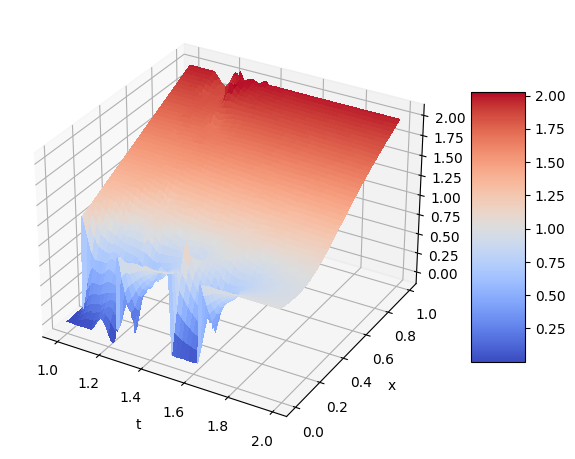

In [50]:
sol.plot2d(func_num=0)

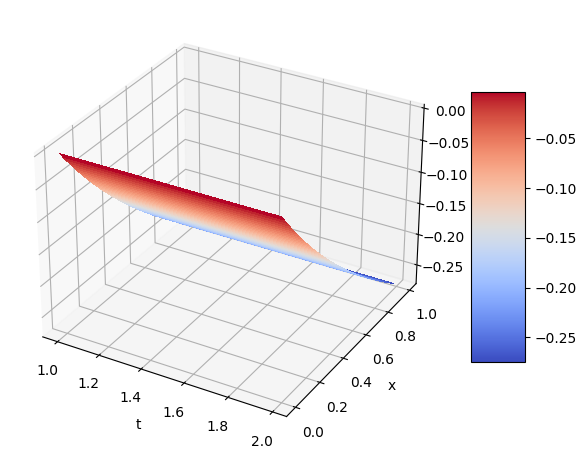

In [51]:
sol.plot2d(func_num=1)

## Weights experiments

In [ ]:
n=4
cweight_list = [2**i for i in range(n)]

bweight_list = [2**i for i in range(n)]

conditions = np.empty((n,n))

for bw, i in  zip(bweight_list, range(n)):
    for cw, j in zip(cweight_list, range(-2, n-2)):
        weights = {'border_weight':bw, 
        'colloc_weight':cw, 
        'connect_weights':[1,1]
        }
        sol, iteration_dict = prepare_model(**weights)
        A, b = sol.global_solve(solver = 'SVD', **iteration_dict, calculate = False, return_system=True, alpha = 0, verbose=True)
        conditions[i,j] = np.linalg.cond(A)

KeyboardInterrupt: 